## Ensembles of Decision Trees

*Ensembles* are methods that combine multiple machine learning models to create more powerful models.  *Random forests* and *gradient-boosted decision trees* are two ensemble models that have proven to be effective on a wide range of datasets for classification and regression.  Both use decision trees as their building blocks.

### Random Forests

A main drawback of decision trees is that they tend to overfit the training data.  Random forests are one way to address this problem.  

A *random forest* is essentially a collection of decision trees, where each tree is slightly different from the others.  The idea behind random forests is that each tree might do a relatively good job of predicting, but will likely overfit on part of the data.  If we build many trees, all of which work well and overfit in different ways, we can reduce the amount of overfitting by averaging their results.  This reduction of overfitting can be shown using rigorous mathematics.

To implement this strategy, we need to build many decision trees.  Each tree should do an acceptable job of predicting the target, and should be different from the other trees.

Random forests get their name from injecting randomness into the tree building to ensure each tree is different.  There are 2 ways in which the trees in a random forest are randomized:
- By selecting the data points used to build a tree
- By selecting the features in each test split

### Building Random Forests

To build a random forest model, you need to decide on the number of trees to build (the *n_estimators* parameter of *RandomForestRegressor* or *RandomForestClassifier*).  Let's say we want to build 10 trees.  These trees will be completely independent of each other, and the algorithm will make different random choices for each tree to make sure the trees are distinct.

To build a tree, we first take what is called a *bootstrap sample* of our data.  That is, from our *n_samples* data points, we repeatedly draw an example randomly with replacement, *n_samples* times.  This will create a dataset that is as big as the original dataset, but some data points will be missing from it (approximately 1/3) and some will be repeated

Next, a decision tree is built based on this newly created dataset.  However, the algorithm we described for the decision tree is slightly modified.  Instead of looking for the best test for each node, in each node the algorithm randomly selects a subset of features, and it looks for the best possible test involving one of these features.  The number of features that are selected is controlled by the *max_features* parameter.  This selection of a subset of features is repeated separately in each node, so that each node in a tree can make a decision using a different subset of the features.

The bootstrap sampling leads to each decision tree in the random forest being built on a slightly different dataset.  Because of the selection of features in each node, each split in each tree operates on a different subset of features.  Together, these two mechanisms ensure that all the trees in the random forest are different.

The selection of *max_features* is critical.  If we set *max_features* to *n_features*, that means each split can look at all features in the dataset, and no randomness will be injected into the feature selection.  This means the trees in the forest will be quite similar.  If we set *max_features* to 1, that means the splits have no choice at all on which features to test, and can only search over different thresholds for the feature that was selected randomly.  This means the trees in the forest will be quite different.

To make a prediction using the random forest, the algorithm first makes a prediction for every tree in the forest.  For regression, we can average these results to get our final prediction.  

For classification, a *soft voting* strategy is used.  Each algorithm makes a soft prescription, providing a probability for each possible output label.  The probabilities predicted by all the trees are averaged, and the class with the highest probability is predicted.

### Analyzing Random Forests

Let's apply a random forest consisting of 5 trees to the *two_moons* dataset we studied earlier.

In [2]:
# Standard imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy as sp
import sklearn
from IPython.display import display
import mglearn

# Don't display deprecation warnings
import warnings
warnings.filterwarnings('ignore')

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=100, noise=0.25, random_state=3)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

In [5]:
forest = RandomForestClassifier(n_estimators=5, random_state=2)
forest.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=5, n_jobs=None,
            oob_score=False, random_state=2, verbose=0, warm_start=False)

The trees that are built as part of the random forest are stored in the *estimator_* attribute.  Let's visualize the decision boundaries learned by each tree, together with their aggregation prediction as made by the forest.

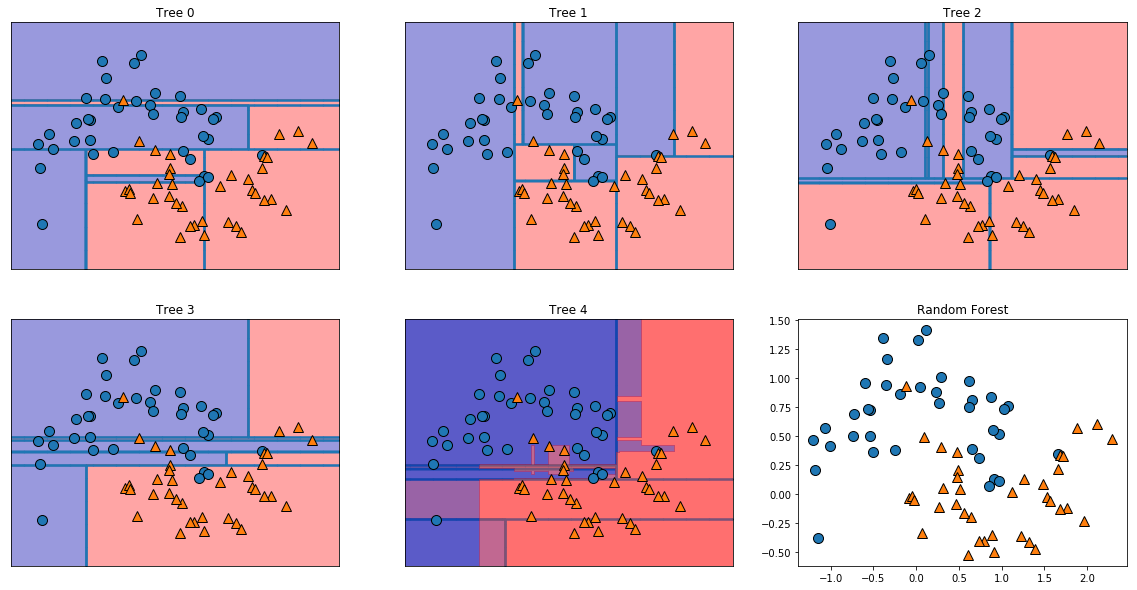

In [6]:
fig, axes = plt.subplots(2, 3, figsize=(20, 10))

for i, (ax, tree) in enumerate(zip(axes.ravel(), forest.estimators_)):
    ax.set_title("Tree {}".format(i))
    mglearn.plots.plot_tree_partition(X_train, y_train, tree, ax=ax)
    
mglearn.plots.plot_2d_separator(forest, X_train, fill=True, ax=axes[-1, 1], alpha=0.4)
axes[-1, -1].set_title("Random Forest")
mglearn.discrete_scatter(X_train[:, 0], X_train[:, 1], y_train)

We can see that the decision boundaries learned by the 5 trees are quite different.  Each of them makes some mistakes.

The random forest overfits less than any of the trees individually, and provides a much more intuitive decision boundary.  In any real application, we would use many more trees (hundreds or thousands), leaving to even smoother boundaries.

As another example, let's apply a random forest consisting of 100 trees on the *Breast Cancer* dataset.

In [10]:
from sklearn.datasets import load_breast_cancer

cancer = load_breast_cancer()
X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, random_state=0)

forest = RandomForestClassifier(n_estimators=100, random_state=0)
forest.fit(X_train, y_train)

print("Accuracy on training set: {:.3f}".format(forest.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(forest.score(X_test, y_test)))

Accuracy on training set: 1.000
Accuracy on test set: 0.972


The random forest gives us an accuracy of 97%, better than the linear models or a single decision tree, without tuning any parameters.  We could adjust the *max_features* setting, or apply pre-pruning as we did for the single decision tree.  However, often the default parameters of the random forest already work quite well.

Similarly to the decision tree, the random forest provides feature importances, which are computed by aggregating the feature importances over the trees in the forest.  Typically, the feature importances provided by the random forest are more reliable than the ones provided by a single tree.

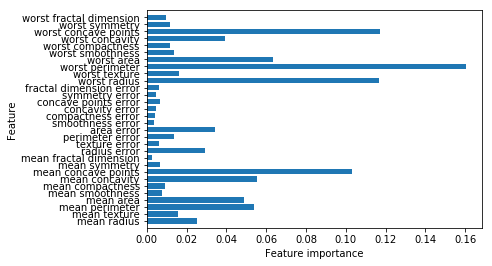

In [12]:
def plot_feature_importances_cancer(model):
    n_features = cancer.data.shape[1]
    plt.barh(np.arange(n_features), model.feature_importances_, align='center')
    plt.yticks(np.arange(n_features), cancer.feature_names)
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")
    plt.ylim(-1, n_features)

plot_feature_importances_cancer(forest)

### Strengths, Weaknesses, and Parameters

Random forests for regression and classification are currently among the most widely used machine learning methods.  They are very powerful, often work well without heavy tuning of the parameters, and don't require scaling of the data.

Essentially, random forests share all of the benefits of decision trees, while making up for some of their deficiencies.  One reason you may want to revert to using a single decision tree is that it gives a compact representation of the decision making process, while it is much harder to interpret many trees in detail.  If you need to summarize the prediction-making to non-experts, a single decision tree may work better.

Since random forest construction is easily parallelized, the *n_jobs* parameter can be used to specify how many CPU cores should be used.  Using more cores will result in linear speed-ups.  To use all the computers cores, we can specify *n_jobs=-1*.

We should keep in mind that random forests are random in nature, and setting different random states (or not setting the *random_state* at all) can drastically change the model that is built.  The more trees in the forest, the more robust it will be against the choice of random state.  If we want to have reproducible results, it is important to fix the *random_state*.

Random forests don't tend to perform well on very high-dimensional, sparse data, such as text data.  For this kind of data, linear models might be more appropriate.  Random forests usually work on very large datasets, and training can easily be parallelized over many CPU cores within a powerful computer.  However, random forests require more memory and are slower to train and predict than linear models.  It time and memory are important in an application, it might make sense to use a linear model instead.

The important parameters to adjust are *n_estimators*, *max_features*, and possibly pruning options like *max_depth*.  For *n_estimators*, large is always better.  A common rule of thumb is to build as many trees as you have time/memory for.  A good rule of thum for *max_features* is to use the default value of *max_features=sqrt(n_features)* for classification and *max_features=n_features* for regression.  Adding *max_depth* or *max_leaf_nodes* can sometimes improve performance, and it can also drastically reduce space/time requirements.

### Gradient Boosted Regression Trees (Gradient Boosting Machines)

The *Gradient Boosted Regression Tree* is another ensemble method that combines multiple decistion trees to create a more powerful model.  Despite the name, these models can be used for both regression and classification.  In contrast to random forests, gradient boosting works by building trees in a serial manner, where each tree tries to correct the mistakes of the previous one.

By default, there is no randomization in gradient boosted regression trees.  Instead, strong pre-pruning is used.  Gradient boosted trees often use very shallow trees, of depth 1-5, which makes the model smaller in terms of memory and makes predictions faster.

The main idea behind gradient boosting is to combine many simple models (known as *weak learners*), like shallow trees.  Each tree can only provide good predictions on part of the data, and so more and more trees are added to iteratively improve performance.

Gradient boosted trees are frequently the winning entries in machine learning competitions, and are widely used in industry.  The are generally a bit more sensitive to parameter settings than random forests, but can provide better accuracy if the parameters are set correctly.

Apart from pre-pruning and the number of trees in the ensemble, another important parameter of gradient boosting is the *learning_rate*, which controls how strongly each tree tries to correct the mistakes of previous trees.  A higher learning rate means each tree can make stronger corrections, allowing for more complex models.  Adding more trees to the ensemble, which can be accomplished by increasing *n_estimators*, also increases the model complexity, as the model has more chances to correct mistakes on the training set.